I'm basing this kaggle on my previous [Plant Seedling - Simple CNN](https://www.kaggle.com/masonblier/plant-seedling-simple-cnn) kaggle notebook. 

In [1]:
import gc
import glob
import os
import cv2
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import imageio as im
import keras
from keras import models
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['train', 'test', 'train.csv', 'sample_submission.csv']


Here I write the function for loading and preprocessing the image data. There's only one target category in this dataset so I show the first 8 images. 

../input/train/train/*.jpg
train labels: train
17500


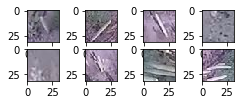

In [2]:
# load images dataset
def loadImagesData(glob_path):
    images = []
    names = []
    for img_path in glob.glob(glob_path):
        # load/resize images with cv2
        names.append(os.path.basename(img_path))
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        images.append(img) # already 32x32
    return (images,names)
# map of training label to list of images
trainData = {}
namesData = {}
for label in os.listdir('../input/train/'):
    (images,names) = loadImagesData(f"../input/train/{label}/*.jpg")
    print(f"../input/train/{label}/*.jpg")
    trainData[label] = images
    namesData[label] = names
print("train labels:", ",".join(trainData.keys()))
print(len(trainData['train']))
# show some data
plt.figure(figsize=(4,2))
columns = 4
for i in range(0,8):
    plt.subplot(8 / columns + 1, columns, i + 1)
    plt.imshow(trainData['train'][i])
plt.show()

Checking out the train.csv data, use value_counts to check relative number of 0 and 1 has_cactus values

In [3]:
train_meta = pd.read_csv('../input/train.csv')
print(train_meta.shape)
print(train_meta.has_cactus.value_counts())
# lookup table of name to has_cactus
lookupY = {}
for i in range(0,len(train_meta)):
    row = train_meta.iloc[i,:]
    lookupY[row.id] = row.has_cactus
train_meta.head()

(17500, 2)
1    13136
0     4364
Name: has_cactus, dtype: int64


,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


Build a dataframe of all the x and y data. I then build a more even dataset of 50% 0 and 1 to help the training process.

In [4]:
# build x/y dataset
trainList = []
maxCount = 4364 # number of has_cactus = 0
counts = {'0':0,'1':0}
for (i,image) in enumerate(trainData['train']):
    label = lookupY[namesData['train'][i]]
    counts[str(label)] = 1 + counts[str(label)]
    if counts[str(label)] < maxCount:
        trainList.append({
            'label': label,
            'data': image
        })
# shuffle dataset
random.shuffle(trainList)
# dataframe and display
train_df = pd.DataFrame(trainList)
gc.collect()
print(train_df.shape)
print(train_df.label.value_counts())
train_df.head()

(8726, 2)
1    4363
0    4363
Name: label, dtype: int64


,data,label
0,"[[[121, 121, 139], [115, 115, 133], [115, 115,...",0
1,"[[[131, 134, 148], [128, 131, 145], [144, 147,...",0
2,"[[[125, 132, 152], [121, 128, 148], [118, 125,...",0
3,"[[[133, 142, 152], [140, 149, 159], [138, 147,...",0
4,"[[[126, 104, 123], [105, 83, 102], [164, 144, ...",1


Encode x data as numpy stack

In [5]:
# encode training data
data_stack = np.stack(train_df['data'].values)
dfloats = data_stack.astype(np.float)
all_x = np.multiply(dfloats, 1.0 / 255.0) # np.array(train_df['data'].values, dtype=np.float) / 255.0
print(all_x.shape)
print(type(all_x))
all_x[0,0,0,0]

(8726, 32, 32, 3)
<class 'numpy.ndarray'>


0.4745098039215686

Since we use binary_crossentropy, the y category data just needs to be made as floats

In [6]:
all_y = np.array(train_df.label).astype(np.float)
all_y[0:5]

array([0., 0., 0., 0., 1.])

Make the training/validation split to measure training accuracy

In [7]:
# split test/training data
train_x,test_x,train_y,test_y=train_test_split(all_x,all_y,test_size=0.2,random_state=7)
print(train_x.shape,test_x.shape)

(6980, 32, 32, 3) (1746, 32, 32, 3)


Here I define the data augmenter. I use x,y and rotation as the images were taken from aerial and thus can vary in these ways.

In [8]:
# x,y and rotation data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    rotation_range=60,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.2, # zoom images
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True)  # randomly flip images
datagen.fit(train_x)

Starting with the simple stacked 3x3 conv net from Towards Data Science

In [ ]:
# create the network
num_filters = 8
input_shape = train_x.shape[1:]
output_shape = 1
# model
m = Sequential()
def tdsNet(m):
    m.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    m.add(Conv2D(16, kernel_size=3, activation='relu'))
    m.add(Flatten())
    m.add(Dropout(0.5)) # increases val_acc from 0.89 to 0.92, acc from 0.8932 to 0.8987
#     m.add(BatchNormalization()) # val_acc falling from 0.89 to 0.8322
    m.add(Dense(units = output_shape, activation='sigmoid'))
tdsNet(m)
# compile adam with decay and use binary_crossentropy for single category dataset
m.compile(optimizer = 'nadam',
          loss = 'binary_crossentropy', 
          metrics = ['accuracy'])
# show summary
m.summary()

In [ ]:
# train model
batch_size = 32
history = m.fit_generator(datagen.flow(train_x, train_y,
                          batch_size=batch_size),
                          steps_per_epoch= (train_x.shape[0] // batch_size),
                          epochs = 4,
                          validation_data=(test_x, test_y),
                          workers=4)

I found I could do slightly better and have fewer trainable parameters if I use max pooling layers and a dense layer at the end.

In [13]:
# create the network
num_filters = 8
input_shape = train_x.shape[1:]
output_shape = 1
# model
m = Sequential()

def cnnNet(m):
    # Architecture motivated by: https://medium.com/@ksusorokina/image-classification-with-convolutional-neural-networks-496815db12a8
    # Old: CONV => RELU => CONV => RELU => POOL => CONV => RELU => CONV => RELU => POOL => FC
    # New: CONV => RELU => CONV => RELU => CONV => RELU => POOL => CONV => RELU => POOL => FC
    m.add(Conv2D(32, kernel_size=3, input_shape=input_shape)) # 30 # , activation='relu'
    m.add(BatchNormalization())
    m.add(Activation("relu"))
#     m.add(Dropout(0.25)) # remove 14.04 # add 1.04
    
#     m.add(MaxPooling2D(2,2)) # exluded 18.03
    # Second Conv2D layer
    m.add(Conv2D(32, kernel_size=3)) # 15 # , activation='relu'
    m.add(BatchNormalization())
    m.add(Activation("relu"))
#     m.add(MaxPooling2D(2,2)) # removed 13.04 # put back 30.03
    m.add(Dropout(0.25)) # add 30.03
    
    # Third Conv2D layer
    m.add(Conv2D(64, kernel_size=3)) # , activation='relu'
    m.add(BatchNormalization())
    m.add(Activation("relu"))
    m.add(Dropout(0.25)) # add 31.03
    # m.add(MaxPooling2D(2,2)) # removed from here 30.03 - 00:23
    
    # Fourth Conv2D layer
    m.add(Conv2D(64, kernel_size=3)) # change 6.04 # 128 # change 31.03 # 64 # , activation='relu'
    m.add(BatchNormalization())
    m.add(Activation("relu"))
    m.add(MaxPooling2D(2,2)) # add 13.04
    m.add(Dropout(0.25)) # added 6.04 - VGG like
    
    ## VGG like
    m.add(Conv2D(128, kernel_size=3)) # , activation='relu'
    m.add(BatchNormalization())
    m.add(Activation("relu"))
    m.add(Dropout(0.25)) # add 31.03
    # m.add(MaxPooling2D(2,2)) # removed from here 30.03 - 00:23
    
    # Fourth Conv2D layer
    m.add(Conv2D(128, kernel_size=3)) # change 6.04 # 128 # change 31.03 # 64 # , activation='relu'
    m.add(BatchNormalization())
    m.add(Activation("relu"))
    ## VGG like
    
    m.add(MaxPooling2D(2,2))
    m.add(Dropout(0.25)) # add 21.03
    
    m.add(Flatten())
    
    # add 6.04
#     m.add(Dense(256, activation='relu'))
#     m.add(BatchNormalization())
#     m.add(Dropout(0.5))
    # add 6.04
    
    m.add(Dense(64, activation='relu')) # 128 # 7 # <7 stops working, but higher values do nothing
    m.add(BatchNormalization())
#     m.add(Flatten()) # moved two lines up 18.03
    m.add(Dropout(0.5)) # makes no sense: make acc and val_acc lower # increases val_acc from 0.9404 to .., acc from 0.9226 to ..
    m.add(Dense(units = output_shape, activation='sigmoid')) #

'''
# LeNet
def cnnNet(m):
    m.add(Conv2D(20, 5, padding='same', input_shape=input_shape)) # size: 5
    m.add(Activation('relu'))
    m.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    m.add(Conv2D(50, 5, padding='same')) # size: 5
    m.add(Activation('relu'))
    m.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    m.add(Flatten())
    m.add(Dense(500)) #
    m.add(Activation('relu'))
    
    m.add(Dense(units = output_shape))
    m.add(Activation("sigmoid")) # softmax
'''
    
cnnNet(m)
# compile adam with decay and use binary_crossentropy for single category dataset
m.compile(optimizer = 'nadam', # 'nadam',
          loss = 'binary_crossentropy', 
          metrics = ['accuracy'])
# show summary
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_8 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
activation_7 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_9 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
activation_8 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 28, 28, 32)        0         
__________

In [14]:
### train model
batch_size = 64 # 32
history = m.fit_generator(datagen.flow(train_x, train_y,
                          batch_size=batch_size),
                          steps_per_epoch= (train_x.shape[0] // batch_size),
                          epochs = 95, # 10, # 4,
                          validation_data=(test_x, test_y),
                          workers=4)

Epoch 1/95
218/218 [==============================] - 14s 64ms/step - loss: 0.2238 - acc: 0.9130 - val_loss: 0.2311 - val_acc: 0.8960
Epoch 2/95
218/218 [==============================] - 11s 50ms/step - loss: 0.1062 - acc: 0.9633 - val_loss: 0.1057 - val_acc: 0.9609
Epoch 3/95
218/218 [==============================] - 11s 51ms/step - loss: 0.0746 - acc: 0.9733 - val_loss: 0.2042 - val_acc: 0.9277
Epoch 4/95
218/218 [==============================] - 11s 50ms/step - loss: 0.0792 - acc: 0.9725 - val_loss: 0.0682 - val_acc: 0.9746
Epoch 5/95
218/218 [==============================] - 11s 50ms/step - loss: 0.0587 - acc: 0.9805 - val_loss: 0.0742 - val_acc: 0.9746
Epoch 6/95
218/218 [==============================] - 11s 50ms/step - loss: 0.0513 - acc: 0.9817 - val_loss: 0.2058 - val_acc: 0.9151
Epoch 7/95
218/218 [==============================] - 11s 50ms/step - loss: 0.0500 - acc: 0.9843 - val_loss: 0.0573 - val_acc: 0.9806
Epoch 8/95
218/218 [==============================] - 11s 50ms

Epoch 62/95
218/218 [==============================] - 10s 47ms/step - loss: 0.0225 - acc: 0.9920 - val_loss: 0.0109 - val_acc: 0.9969
Epoch 63/95
218/218 [==============================] - 10s 46ms/step - loss: 0.0209 - acc: 0.9925 - val_loss: 0.0272 - val_acc: 0.9914
Epoch 64/95
218/218 [==============================] - 10s 46ms/step - loss: 0.0146 - acc: 0.9951 - val_loss: 0.0347 - val_acc: 0.9897
Epoch 65/95
218/218 [==============================] - 10s 46ms/step - loss: 0.0175 - acc: 0.9948 - val_loss: 0.0281 - val_acc: 0.9926
Epoch 66/95
218/218 [==============================] - 10s 46ms/step - loss: 0.0199 - acc: 0.9933 - val_loss: 0.0222 - val_acc: 0.9926
Epoch 67/95
218/218 [==============================] - 10s 46ms/step - loss: 0.0186 - acc: 0.9938 - val_loss: 0.0271 - val_acc: 0.9923
Epoch 68/95
218/218 [==============================] - 10s 45ms/step - loss: 0.0205 - acc: 0.9936 - val_loss: 0.4052 - val_acc: 0.9109
Epoch 69/95
218/218 [==============================] - 

Finish training on the rest of the data

In [15]:
# build complete x/y dataset
trainList = []
for (i,image) in enumerate(trainData['train']):
    label = lookupY[namesData['train'][i]]
    trainList.append({
        'label': label,
        'data': image
    })
# shuffle dataset
random.shuffle(trainList)
# dataframe and display
train_df = pd.DataFrame(trainList)
gc.collect()
# encode training data
data_stack = np.stack(train_df['data'].values)
dfloats = data_stack.astype(np.float)
all_x = np.multiply(dfloats, 1.0 / 255.0)
all_x.shape
all_y = np.array(train_df.label).astype(np.float)
# split test/training data
train_x,test_x,train_y,test_y=train_test_split(all_x,all_y,test_size=0.2,random_state=7)
print(train_x.shape,test_x.shape)

(14000, 32, 32, 3) (3500, 32, 32, 3)


In [16]:
###### continue training model
batch_size = 128 # 64 # 
history = m.fit_generator(datagen.flow(train_x, train_y,
                          batch_size=batch_size),
                          steps_per_epoch= (train_x.shape[0] // batch_size),
                          epochs = 95, # 10, # 4,
                          validation_data=(test_x, test_y),
                          workers=4)

Epoch 1/95
109/109 [==============================] - 10s 88ms/step - loss: 0.0140 - acc: 0.9958 - val_loss: 0.0052 - val_acc: 0.9980
Epoch 2/95
109/109 [==============================] - 9s 85ms/step - loss: 0.0099 - acc: 0.9963 - val_loss: 0.0062 - val_acc: 0.9971
Epoch 3/95
109/109 [==============================] - 9s 84ms/step - loss: 0.0087 - acc: 0.9968 - val_loss: 0.0071 - val_acc: 0.9980
Epoch 4/95
109/109 [==============================] - 9s 83ms/step - loss: 0.0121 - acc: 0.9963 - val_loss: 0.0071 - val_acc: 0.9980
Epoch 5/95
109/109 [==============================] - 9s 83ms/step - loss: 0.0109 - acc: 0.9963 - val_loss: 0.0084 - val_acc: 0.9971
Epoch 6/95
109/109 [==============================] - 9s 83ms/step - loss: 0.0118 - acc: 0.9961 - val_loss: 0.1090 - val_acc: 0.9749
Epoch 7/95
109/109 [==============================] - 9s 84ms/step - loss: 0.0105 - acc: 0.9965 - val_loss: 0.0145 - val_acc: 0.9951
Epoch 8/95
109/109 [==============================] - 10s 88ms/step 

109/109 [==============================] - 9s 85ms/step - loss: 0.0093 - acc: 0.9968 - val_loss: 0.0055 - val_acc: 0.9983
Epoch 63/95
109/109 [==============================] - 9s 85ms/step - loss: 0.0065 - acc: 0.9983 - val_loss: 0.0100 - val_acc: 0.9960
Epoch 64/95
109/109 [==============================] - 9s 84ms/step - loss: 0.0096 - acc: 0.9967 - val_loss: 0.0178 - val_acc: 0.9951
Epoch 65/95
109/109 [==============================] - 9s 85ms/step - loss: 0.0094 - acc: 0.9966 - val_loss: 0.0060 - val_acc: 0.9986
Epoch 66/95
109/109 [==============================] - 9s 85ms/step - loss: 0.0083 - acc: 0.9971 - val_loss: 0.1178 - val_acc: 0.9783
Epoch 67/95
109/109 [==============================] - 9s 84ms/step - loss: 0.0109 - acc: 0.9958 - val_loss: 0.4029 - val_acc: 0.9223
Epoch 68/95
109/109 [==============================] - 9s 85ms/step - loss: 0.0087 - acc: 0.9976 - val_loss: 0.0080 - val_acc: 0.9974
Epoch 69/95
109/109 [==============================] - 9s 85ms/step - loss

In [ ]:
# check sample submission format
pd.read_csv('../input/sample_submission.csv').head()

Output predictions file

In [ ]:
# output predicted submission csv
(test_images, test_names) = loadImagesData(f"../input/test/test/*.jpg")
data_stack = np.stack(test_images)
dfloats = data_stack.astype(np.float32)
unknown_x = np.multiply(dfloats, 1.0 / 255.0)
# predict
predicted = np.ravel(m.predict(unknown_x))
submission_df = pd.DataFrame({'id':test_names,'has_cactus':predicted})
submission_df.to_csv('submission.csv', index=False)
len(submission_df)